<a href="https://colab.research.google.com/github/vubanc/BikeTimeSeriesAnalysis/blob/main/TimeSeriesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing the Libraries and Notebooks**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from pandas import datetime
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

<ipython-input-15-eba961249c64>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Work/Bikesharing/CombinedRentals_AllStations.csv")
df.head(2)

,index,id,user,user_id,user_phone,start_station,start_time,start_time_local,end_station,end_time,end_time_local,kilometers,miles,message_count,type,duration (seconds),rating,device_id,bike_type,Date
0,1,34ac1576-891f-4aca-a570-31db6160fd6f,Dara Ochoa,2112677d-b644-4cb8-866d-58f52b932f76,14792852353,Riverfront Park,2023-08-02 01:09:31.952446+00:00,2023-08-01 19:09:31.952446-06:00,Riverfront Park,2023-08-02 01:10:19.952446+00:00,2023-08-01 19:10:19.952446-06:00,NaN,NaN,130,22,48.0,NaN,74164be4e769c0ff30f08acb19724fa186d89b71913e9b...,Regular Bike,2023-08-01
1,2,dc96b3e6-f607-452b-ad18-79ea96e033d9,Gervon Pennington,79ea58b0-0988-47da-b963-a11a52a94f04,19035560048,Riverfront Park,2023-08-02 00:48:53.349677+00:00,2023-08-01 18:48:53.349677-06:00,Riverfront Park,2023-08-02 01:24:14.349677+00:00,2023-08-01 19:24:14.349677-06:00,4.482,2.78498,41,22,2121.0,NaN,fMV1Kdc8Km,Regular Bike,2023-08-01


## **Exploratory Data Analysis**

In [5]:
min_date = df.Date.min()
max_date = df.Date.max()
dates = pd.DataFrame(pd.date_range(start=min_date, end=max_date))
dates.rename(columns={0:"Date"}, inplace=True)
dates.Date = dates.Date.dt.strftime("%Y-%m-%d")
df = pd.merge(df, dates, how="right", on="Date")
df.sort_values(by = ["Date", "start_time"], inplace=True, ascending=[True,True])
df_tripCount = df.groupby("Date", as_index=False)["id"].count()
df_tripCount.rename(columns={"id":"trip_count"}, inplace=True)
df_tripCount.Date = pd.to_datetime(df_tripCount.Date)
df_tripCount.set_index("Date", inplace=True)

Trend

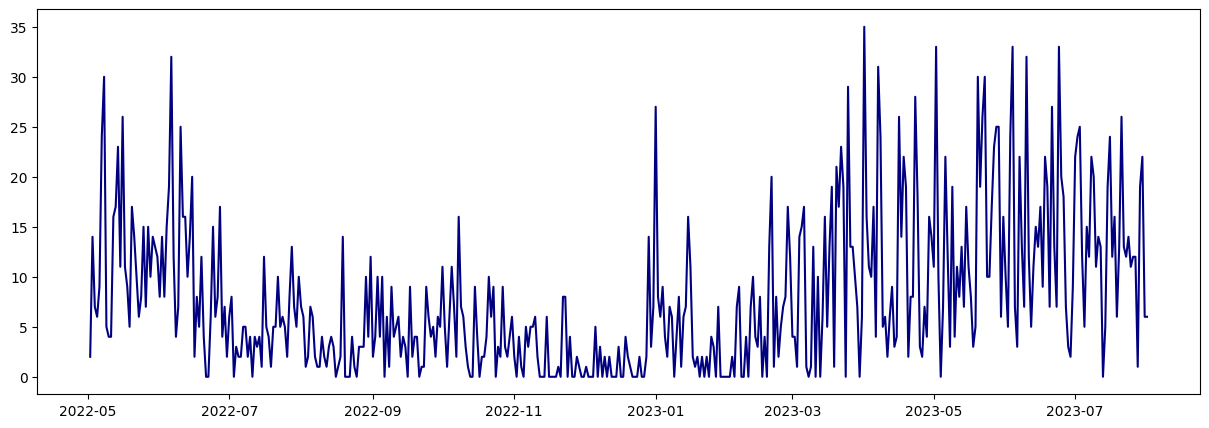

In [6]:
fig, axs = plt.subplots(1,1, figsize=(15,5))
plt.plot(df_tripCount['trip_count'], color="navy")

Autocorrelation

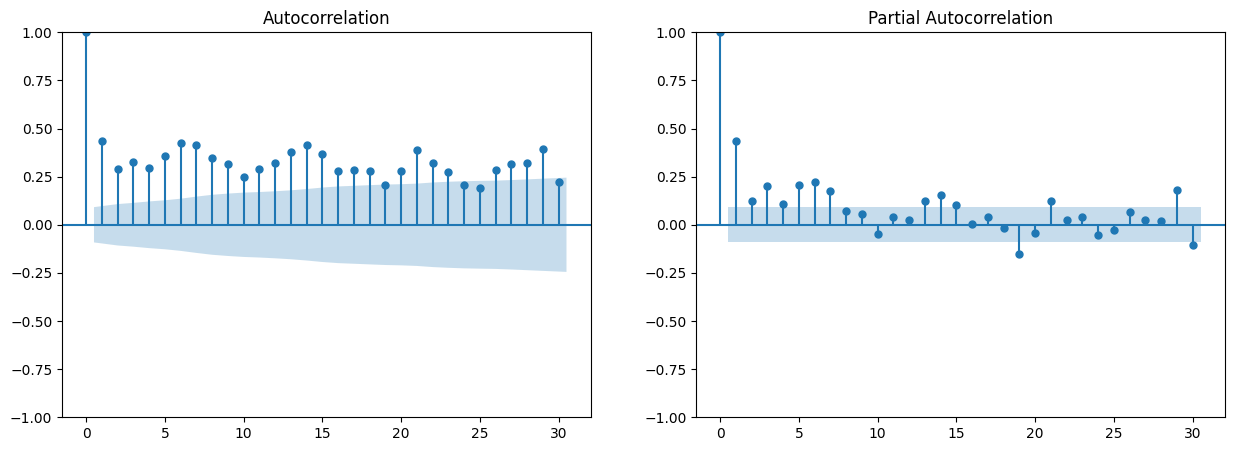

In [28]:
#Autocorrelation and partial autocorrelation plots
fig, axs = plt.subplots(1,2,figsize=(15,5))
plot_acf(x=df_tripCount.trip_count, ax=axs[0], lags=30)
plot_pacf(x=df_tripCount.trip_count, ax=axs[1], lags=30)
plt.show()

Stationarity

In [9]:
#Global vs Local Mean Test
print(f"Global Mean: {df_tripCount.trip_count.mean()}")
print(f"Local Mean: {df_tripCount[250:].trip_count.mean()}")

Global Mean: 7.899343544857768
Local Mean: 10.734299516908212


In [12]:
#Augmented Dickey-Fuller Test
result = adfuller(df_tripCount)
print(f"The ADF test statistic is: {result[0]}")
print(f"The ADF p-value is: {result[1]}")

The ADF test statistic is: -1.967538455776848
The ADF p-value is: 0.30098516341276804


Since the data is not stationary, as indicated by the p-value of the ADF test, none of the traditional time-series models can be directly used for this data. Hence, a lag transformation need to be applied.

In [16]:
df_tripCount["lagged_trip_count"] = df_tripCount["trip_count"].shift(1)
df_tripCount["diff_trip_count"] = df_tripCount["trip_count"] - df_tripCount["lagged_trip_count"]
df_tripCount.fillna(0,inplace=True)
df_tripCount["lagged_trip_count"] = df_tripCount["lagged_trip_count"].astype(int)
df_tripCount["diff_trip_count"] = df_tripCount["diff_trip_count"].astype(int)

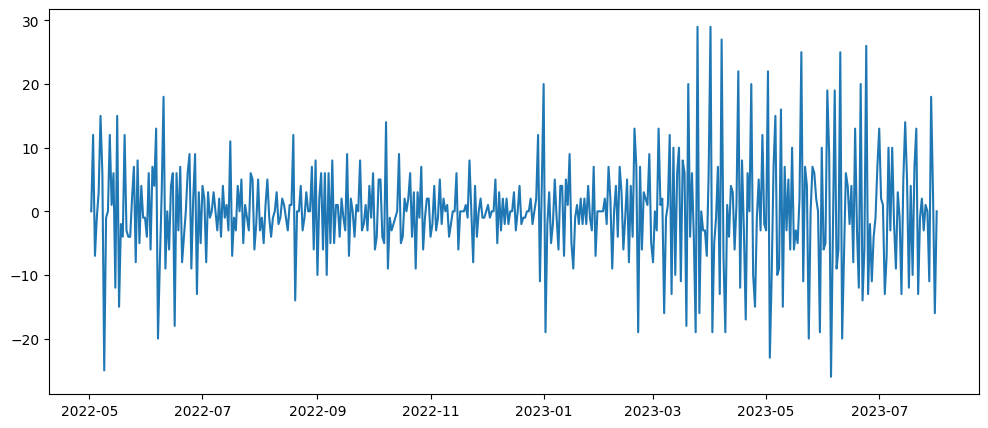

In [30]:
#Applying a Transformation
fig = plt.figure(figsize=(12,5))
plt.plot(df_tripCount.diff_trip_count)

In [21]:
#Augmented Dickey-Fuller Test on the transformed data
result = adfuller(df_tripCount.diff_trip_count)
print(f"The ADF test statistic is: {result[0]}")
print(f"The ADF p-value is: {result[1]}")

The ADF test statistic is: -6.480879566160753
The ADF p-value is: 1.2959848279813883e-08


In [29]:
df_tripCount.head(2)

,trip_count,lagged_trip_count,diff_trip_count
Date,,,
2022-05-02,2,0,0
2022-05-03,14,2,12


## **ARIMA Model Fitting**

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


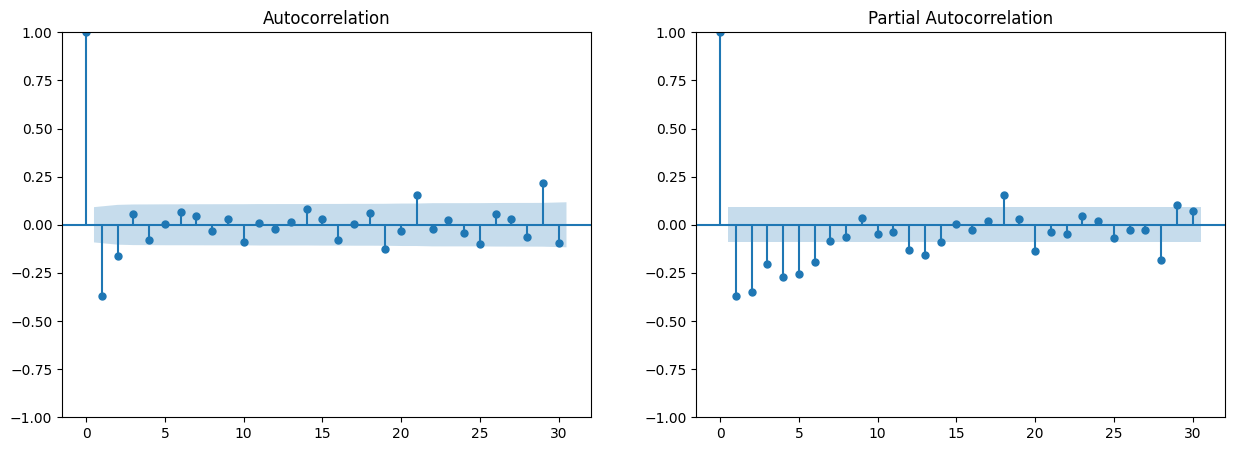

In [32]:
fig, axs= plt.subplots(1,2, figsize=(15,5))
plot_acf(x=df_tripCount.diff_trip_count, ax=axs[0], lags=30)
plot_pacf(x=df_tripCount.diff_trip_count, ax=axs[1], lags=30)
plt.show()

In [79]:
df_train = df_tripCount[["diff_trip_count"]][:'2023-07-25']
df_test = df_tripCount[["diff_trip_count"]]['2023-07-25':]

In [87]:
model = ARIMA(endog=df_train, order=(6,1,2)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:        diff_trip_count   No. Observations:                  450
Model:                 ARIMA(6, 1, 2)   Log Likelihood               -1465.510
Date:                Mon, 07 Aug 2023   AIC                           2949.020
Time:                        04:48:59   BIC                           2985.983
Sample:                    05-02-2022   HQIC                          2963.590
                         - 07-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1234      0.059      2.088      0.037       0.008       0.239
ar.L2         -0.1233      0.047     -2.635      0.008      -0.215      -0.032
ar.L3         -0.0107      0.049     -0.216      0.8

## **ARIMA Model Evaluation**

p-value for ADF test of the residuals is: 0.0


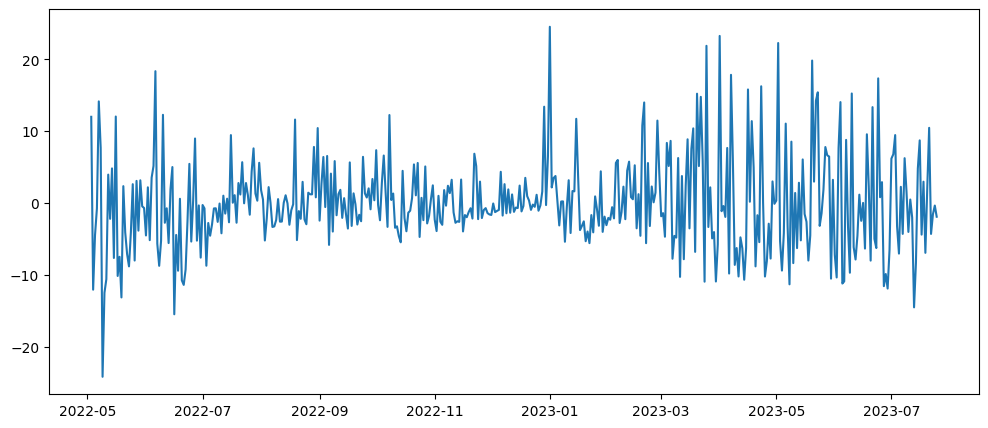

In [88]:
#Checking for white noise in the residuals
residuals = model.resid[1:]
plt.figure(figsize=(12,5))
plt.plot(residuals)
print(f"p-value for ADF test of the residuals is: {adfuller(residuals)[1]}")
plt.show()

In [89]:
predictions = model.predict(start=0, end=len(df_tripCount)-1, dynamic=False)

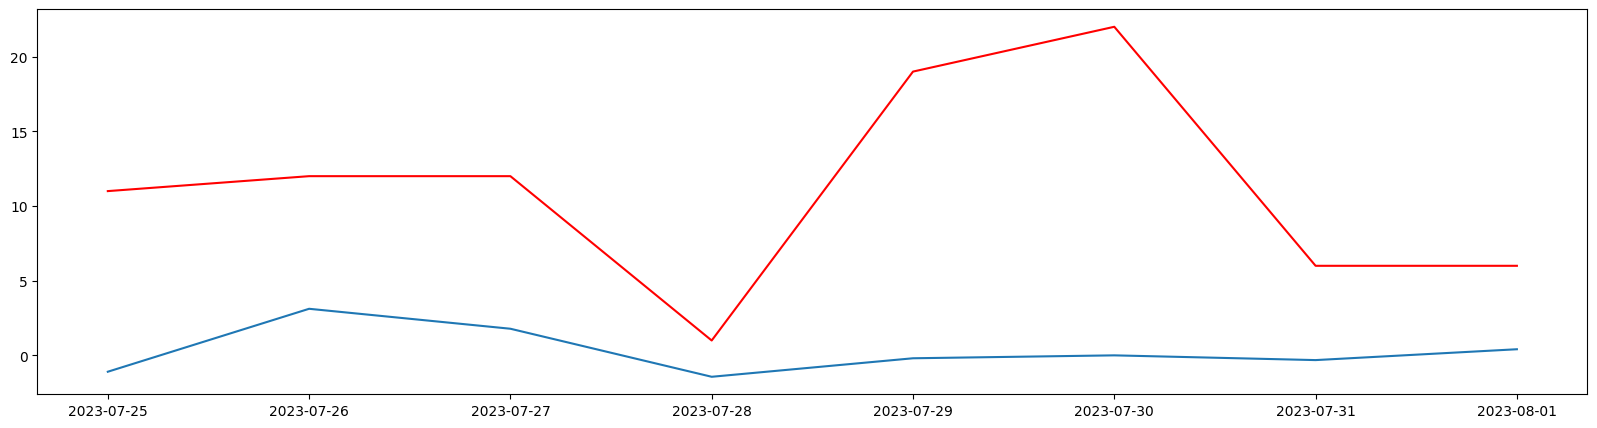

In [90]:
plt.figure(figsize=(20,5))
plt.plot(predictions["2023-07-25":])
plt.plot(df_tripCount["trip_count"]["2023-07-25":], color="red")
plt.show()

In [91]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(df_test, predictions["2023-07-25":]))
print(f"Root mean squared error: {rmse}")

Root mean squared error: 9.280835801648564
